## Import Libraries


In [2]:
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import PyLTSpice
from PyLTSpice import RawRead
from scipy.interpolate import PchipInterpolator
from sklearn.model_selection import train_test_split
from datetime import datetime
from colorama import init, Fore, Style

## Read and Resample LTSpice .raw Files


In [3]:
spice_raw_path = '../ltspice/fuzz_dc/fuzz_dc.raw'
spice_raw = RawRead(spice_raw_path)
print('Traces: ', spice_raw.get_trace_names())

time_raw = spice_raw.get_axis()
time_duration = time_raw[-1]
print(f'Time duration: {time_duration}s')

vb_raw = spice_raw.get_trace('V(vb)').get_wave()
vc_raw = spice_raw.get_trace('V(vc)').get_wave()
# ve_raw = spice_raw.get_trace('V(ve)').get_wave()
ve_raw = np.zeros_like(vb_raw)
vbe_raw = vb_raw - ve_raw
vce_raw = vc_raw - ve_raw
v1_raw = vb_raw - ve_raw
v2_raw = vc_raw - vb_raw

ib_raw = spice_raw.get_trace('Ib(Q1)').get_wave()
ic_raw = spice_raw.get_trace('Ic(Q1)').get_wave()
ie_raw = spice_raw.get_trace('Ie(Q1)').get_wave()
i1_raw = ie_raw
i2_raw = ic_raw

fs_target = 192e3
ts_target = 1.0 / fs_target
num_samples = np.floor(time_duration * fs_target).astype(int) + 1
time_resample = np.linspace(0, time_duration, num_samples)

vb = PchipInterpolator(time_raw, vb_raw)(time_resample)
vc = PchipInterpolator(time_raw, vc_raw)(time_resample)
ve = PchipInterpolator(time_raw, ve_raw)(time_resample)
vbe = PchipInterpolator(time_raw, vbe_raw)(time_resample)
vce = PchipInterpolator(time_raw, vce_raw)(time_resample)
v1 = PchipInterpolator(time_raw, v1_raw)(time_resample)
v2 = PchipInterpolator(time_raw, v2_raw)(time_resample)
ib = PchipInterpolator(time_raw, ib_raw)(time_resample)
ic = PchipInterpolator(time_raw, ic_raw)(time_resample)
ie = PchipInterpolator(time_raw, ie_raw)(time_resample)
i1 = PchipInterpolator(time_raw, i1_raw)(time_resample)
i2 = PchipInterpolator(time_raw, i2_raw)(time_resample)

Traces:  ['time', 'V(n001)', 'V(vc_)', 'V(n002)', 'V(vb_)', 'V(ve_)', 'V(alpha_lin)', 'V(n003)', 'V(n004)', 'V(vc)', 'V(vb)', 'V(x1)', 'V(x2)', 'I(R5)', 'I(R6)', 'I(B2)', 'Ic(Q1_)', 'Ib(Q1_)', 'Ie(Q1_)', 'Ic(Q1)', 'Ib(Q1)', 'Ie(Q1)', 'I(Cin)', 'I(R1)', 'I(R2)', 'I(R3)', 'I(R4)', 'I(Rin)', 'I(Vcc)', 'I(V1)', 'I(Vin)', 'I(V2)', 'I(V5)', 'I(V3)']
Time duration: 2.0s


## Plot Resampled Data and I-V Curve Characteristic Curves


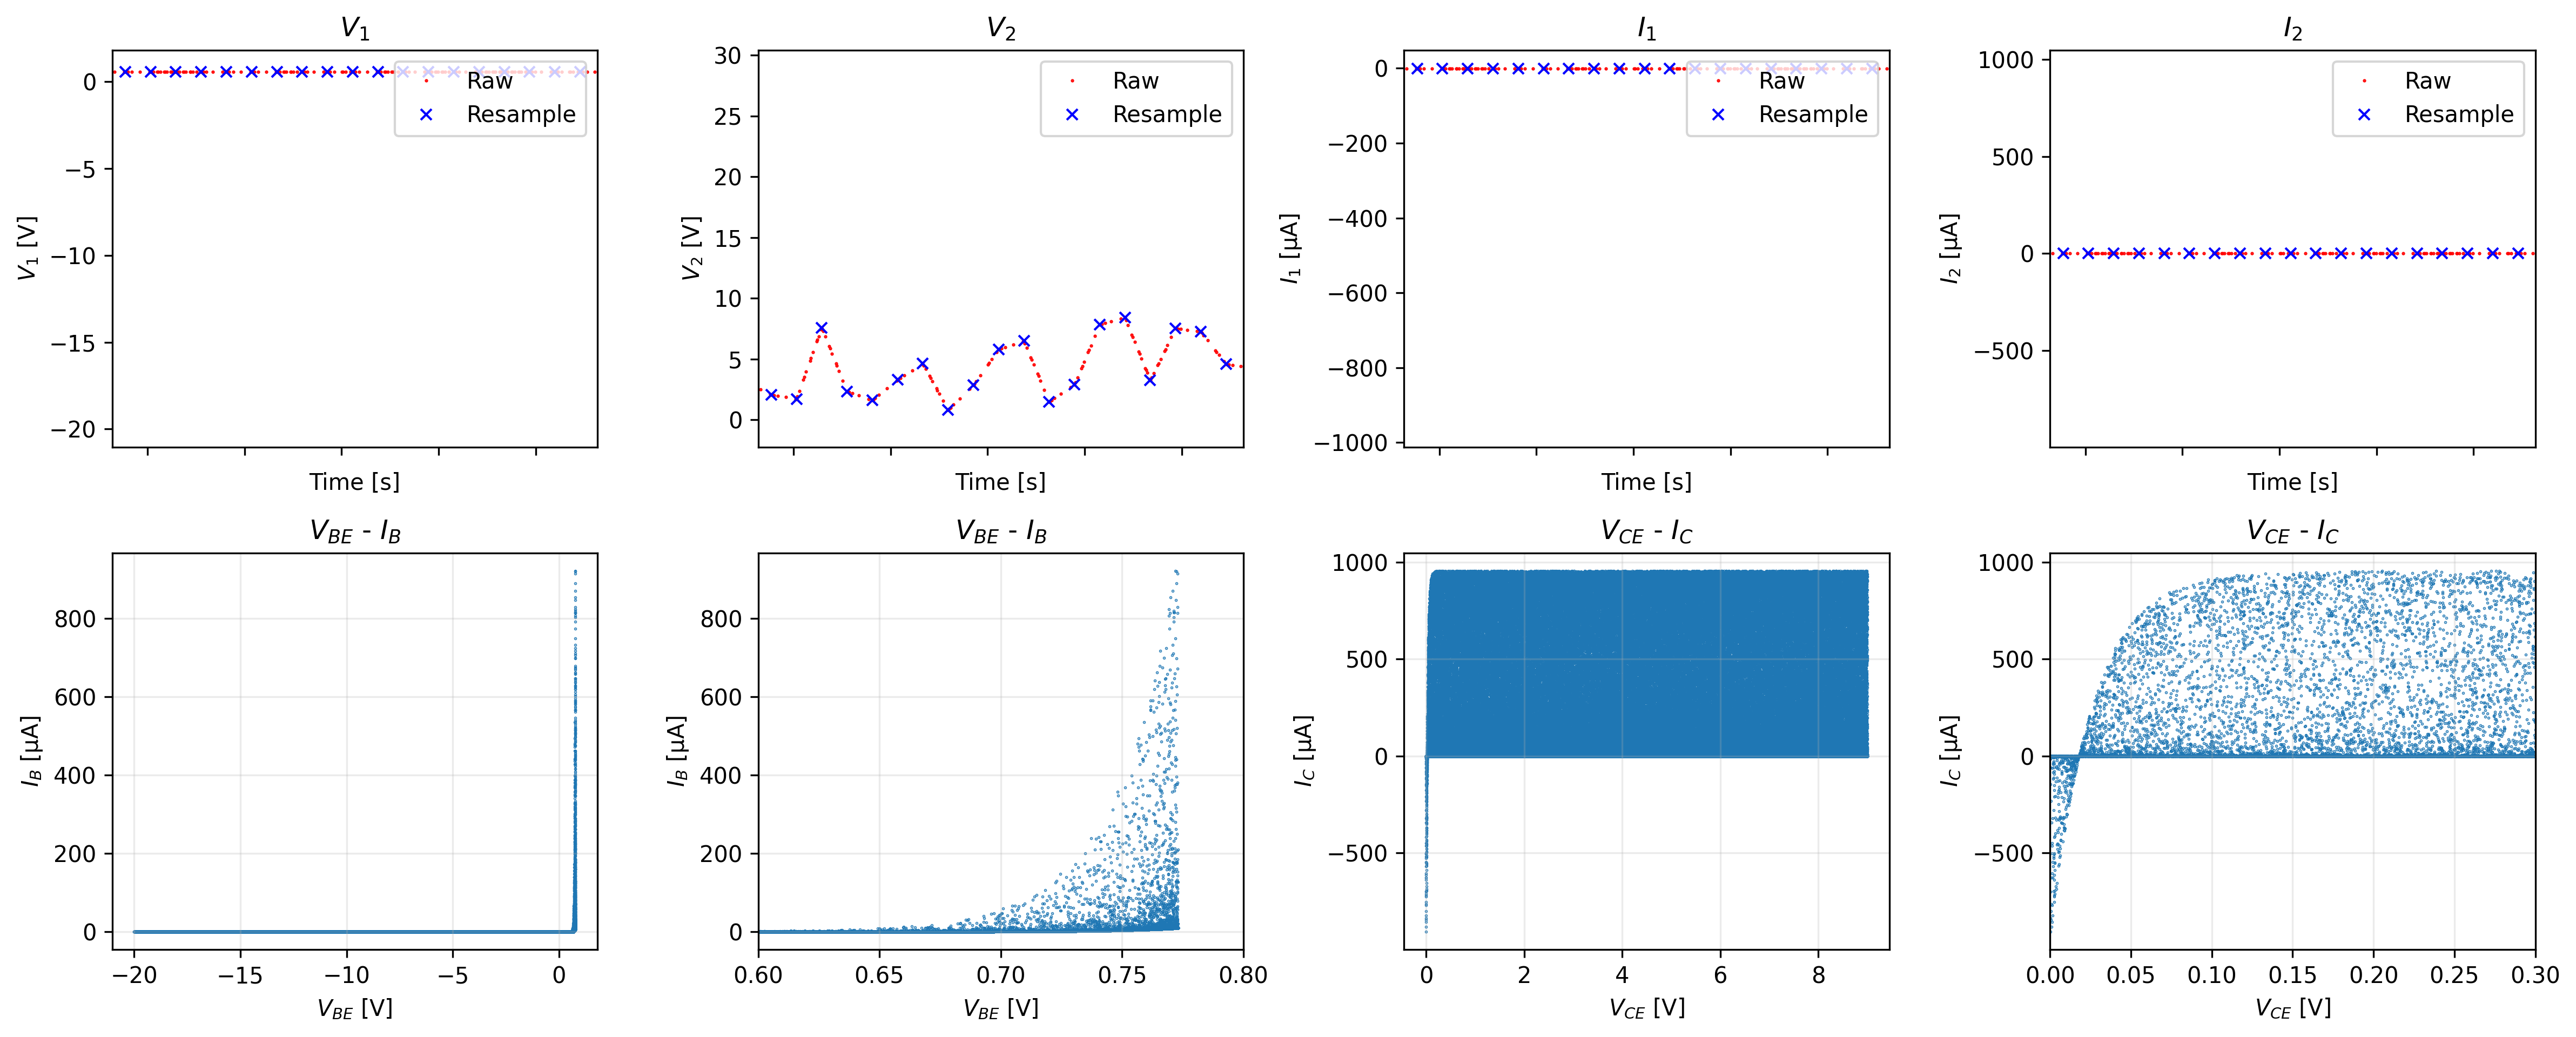

In [4]:
fig, ((ax_v1, ax_v2, ax_i1, ax_i2), 
      (ax_ib, ax_ib_zoom, ax_ic, ax_ic_zoom)) = plt.subplots(2, 4, figsize=(16, 6.5), dpi=300)

markersize_raw = 0.5
markersize_resample = 5
legend_loc = 'upper right'
spotsize = 0.1
grid_alpha = 0.25

interval_width = 1e-4
start_x = np.random.uniform(0, time_duration - interval_width)
end_x = start_x + interval_width
xlim = (start_x, end_x)

ax_v1.plot(time_raw, v1_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_v1.plot(time_resample, v1, 'bx', markersize=markersize_resample, label='Resample')
ax_v1.set_title(r'$V_1$')
ax_v1.set_xlabel('Time [s]')
ax_v1.set_ylabel(r'$V_{1}$ [V]')
ax_v1.legend(loc=legend_loc)
ax_v1.set_xticklabels([])  # 隐藏x轴标签
ax_v1.set_xlim(xlim)

ax_v2.plot(time_raw, v2_raw, 'ro', markersize=markersize_raw, label='Raw')
ax_v2.plot(time_resample, v2, 'bx', markersize=markersize_resample, label='Resample')
ax_v2.set_title(r'$V_2$')
ax_v2.set_xlabel('Time [s]')
ax_v2.set_ylabel(r'$V_{2}$ [V]')
ax_v2.legend(loc=legend_loc)
ax_v2.set_xticklabels([])  # 隐藏x轴标签
ax_v2.set_xlim(xlim)

ax_i1.plot(time_raw, i1_raw*1e6, 'ro', markersize=markersize_raw, label='Raw')
ax_i1.plot(time_resample, i1*1e6, 'bx', markersize=markersize_resample, label='Resample')
ax_i1.set_title(r'$I_1$')
ax_i1.set_xlabel('Time [s]')
ax_i1.set_ylabel(r'$I_{1}$ [μA]')
ax_i1.legend(loc=legend_loc)
ax_i1.set_xticklabels([])  # 隐藏x轴标签
ax_i1.set_xlim(xlim)

ax_i2.plot(time_raw, i2_raw*1e6, 'ro', markersize=markersize_raw, label='Raw')
ax_i2.plot(time_resample, i2*1e6, 'bx', markersize=markersize_resample, label='Resample')
ax_i2.set_title(r'$I_2$')
ax_i2.set_xlabel('Time [s]')
ax_i2.set_ylabel(r'$I_{2}$ [μA]')
ax_i2.legend(loc=legend_loc)
ax_i2.set_xticklabels([])  # 隐藏x轴标签
ax_i2.set_xlim(xlim)

ax_ib.scatter(vbe, ib*1e6, s=spotsize)
ax_ib.set_xlabel(r'$V_{BE}$ [V]')
ax_ib.set_ylabel(r'$I_B$ [μA]')
ax_ib.set_title(r'$V_{BE}$ - $I_B$')
ax_ib.grid(alpha=grid_alpha)

ax_ib_zoom.scatter(vbe, ib*1e6, s=spotsize)
ax_ib_zoom.set_xlabel(r'$V_{BE}$ [V]')
ax_ib_zoom.set_ylabel(r'$I_B$ [μA]')
ax_ib_zoom.set_title(r'$V_{BE}$ - $I_B$')
ax_ib_zoom.grid(alpha=grid_alpha)
ax_ib_zoom.set_xlim(0.6, 0.8)

ax_ic.scatter(vc, ic*1e6, s=spotsize)
ax_ic.set_xlabel(r'$V_{CE}$ [V]')
ax_ic.set_ylabel(r'$I_C$ [μA]')
ax_ic.set_title(r'$V_{CE}$ - $I_C$')
ax_ic.grid(alpha=grid_alpha)
# ax_ic.set_ylim(122.8, 122.9)

ax_ic_zoom.scatter(vc, ic*1e6, s=spotsize)
ax_ic_zoom.set_xlabel(r'$V_{CE}$ [V]')
ax_ic_zoom.set_ylabel(r'$I_C$ [μA]')
ax_ic_zoom.set_title(r'$V_{CE}$ - $I_C$')
ax_ic_zoom.grid(alpha=grid_alpha)
ax_ic_zoom.set_xlim(0, 0.3)
# ax_ic_zoom.set_ylim(122.8, 122.9)


fig.tight_layout()

## Compute Incident and Reflected Waves


In [5]:
z_path = "../Z.hdf5"
with h5py.File(z_path, "r") as file:
    z_matlab = file["/Z"][:].T
z_root = z_matlab[0:2, :, :, 0:2, 0:2].reshape(-1, 2, 2)
print(z_root.shape)

v = np.stack([v1, v2], axis=1)[:, :, np.newaxis]
i = np.stack([i1, i2], axis=1)[:, :, np.newaxis]

v.shape, i.shape



(20402, 2, 2)


((384001, 2, 1), (384001, 2, 1))

In [6]:
a = np.zeros_like(v)
b = np.zeros_like(v)
selected_z_indices = []  # 用于记录选中的z矩阵索引

# 遍历每一对v和i向量
for j in range(v.shape[0]):
    # 从z_root矩阵中随机选择一个z
    z_selected_index = np.random.randint(0, z_root.shape[0])
    z_selected = z_root[z_selected_index]
    
    # 将选中的z矩阵索引保存
    selected_z_indices.append(z_selected_index)
    
    # 进行计算
    a[j] = v[j] + np.matmul(z_selected, i[j])
    b[j] = v[j] - np.matmul(z_selected, i[j])

# 将选中的z矩阵索引转换为NumPy数组，并使用这些索引创建新的z矩阵
selected_z_indices = np.array(selected_z_indices)
selected_z = z_root[selected_z_indices]

a1 = a[:, 0].squeeze()
a2 = a[:, 1].squeeze()
b1 = b[:, 0].squeeze()
b2 = b[:, 1].squeeze()

z11 = selected_z[:, 0, 0]
z12 = selected_z[:, 0, 1]
z21 = selected_z[:, 1, 0]
z22 = selected_z[:, 1, 1]

print("a1 shape:", a1.shape)  # 打印a1向量的形状
print("a2 shape:", a2.shape)  # 打印a2向量的形状
print("b1 shape:", b1.shape)  # 打印b1向量的形状
print("b2 shape:", b2.shape)  # 打印b2向量的形状
print("z11 shape:", z11.shape)  # 打印z11向量的形状
print("z12 shape:", z12.shape)  # 打印z12向量的形状
print("z21 shape:", z21.shape)  # 打印z21向量的形状
print("z22 shape:", z22.shape)  # 打印z22向量的形状
print("z shape:", selected_z.shape)  # 打印新的z矩阵的形状

a1 shape: (384001,)
a2 shape: (384001,)
b1 shape: (384001,)
b2 shape: (384001,)
z11 shape: (384001,)
z12 shape: (384001,)
z21 shape: (384001,)
z22 shape: (384001,)
z shape: (384001, 2, 2)


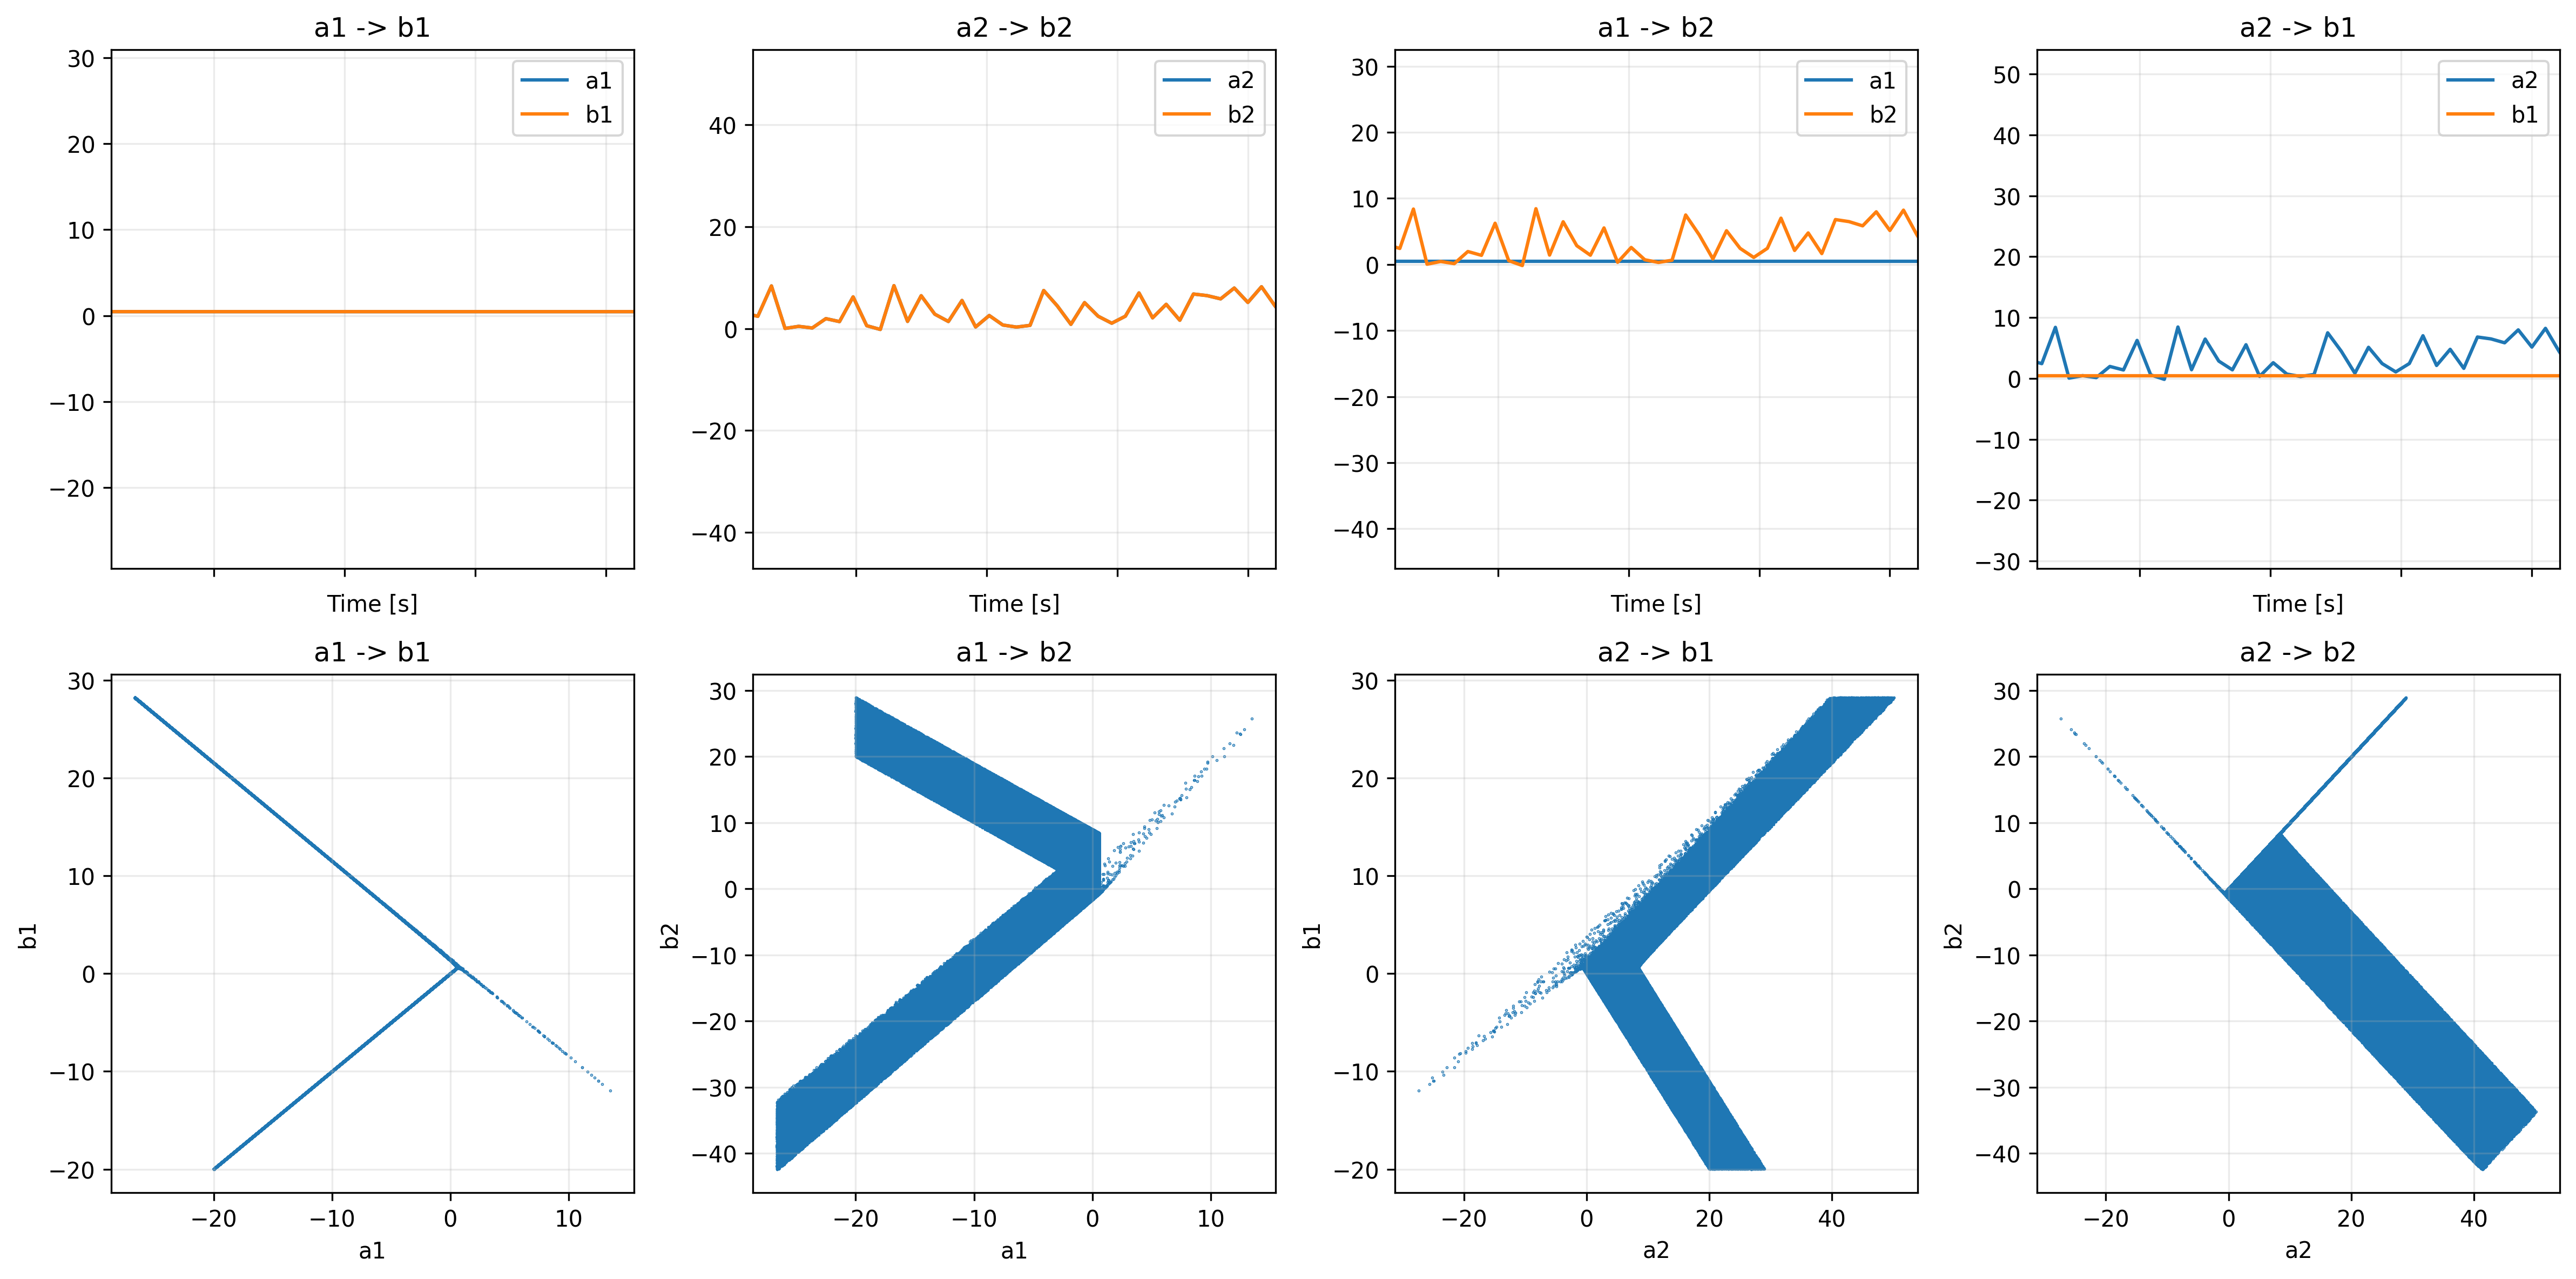

In [10]:
fig, ((ax1, ax2, ax3, ax4),
      (ax_a1b1, ax_a1b2, ax_a2b1, ax_a2b2)) = plt.subplots(2, 4, figsize=(16, 8), dpi=300)

legend_loc = 'upper right'
grid_alpha = 0.25

interval_width = 2e-4
start_x = np.random.uniform(0, time_duration - interval_width)
end_x = start_x + interval_width
xlim = (start_x, end_x)

ax1.plot(time_resample, a1, label='a1')
ax1.plot(time_resample, b1, label='b1')
ax1.set_title('a1 -> b1')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(xlim)
ax1.grid(alpha=grid_alpha)
ax1.legend(loc=legend_loc)
ax1.set_xticklabels([])  # 隐藏x轴标签

ax2.plot(time_resample, a2, label='a2')
ax2.plot(time_resample, b2, label='b2')
ax2.set_title('a2 -> b2')
ax2.set_xlabel('Time [s]')
ax2.set_xlim(xlim)
ax2.grid(alpha=grid_alpha)
ax2.legend(loc=legend_loc)
ax2.set_xticklabels([])  # 隐藏x轴标签

ax3.plot(time_resample, a1, label='a1')
ax3.plot(time_resample, b2, label='b2')
ax3.set_title('a1 -> b2')
ax3.set_xlabel('Time [s]')
ax3.set_xlim(xlim)
ax3.grid(alpha=grid_alpha)
ax3.legend(loc=legend_loc)
ax3.set_xticklabels([])  # 隐藏x轴标签

ax4.plot(time_resample, a2, label='a2')
ax4.plot(time_resample, b1, label='b1')
ax4.set_title('a2 -> b1')
ax4.set_xlabel('Time [s]')
ax4.set_xlim(xlim)
ax4.grid(alpha=grid_alpha)
ax4.legend(loc=legend_loc)
ax4.set_xticklabels([])  # 隐藏x轴标签

ax_a1b1.scatter(a1, b1, s=spotsize)
ax_a1b1.set_xlabel('a1')
ax_a1b1.set_ylabel('b1')
ax_a1b1.set_title('a1 -> b1')
ax_a1b1.grid(alpha=grid_alpha)

ax_a1b2.scatter(a1, b2, s=spotsize)
ax_a1b2.set_xlabel('a1')
ax_a1b2.set_ylabel('b2')
ax_a1b2.set_title('a1 -> b2')
ax_a1b2.grid(alpha=grid_alpha)

ax_a2b1.scatter(a2, b1, s=spotsize)
ax_a2b1.set_xlabel('a2')
ax_a2b1.set_ylabel('b1')
ax_a2b1.set_title('a2 -> b1')
ax_a2b1.grid(alpha=grid_alpha)

ax_a2b2.scatter(a2, b2, s=spotsize)
ax_a2b2.set_xlabel('a2')
ax_a2b2.set_ylabel('b2')
ax_a2b2.set_title('a2 -> b2')
ax_a2b2.grid(alpha=grid_alpha)


fig.tight_layout()
plt.show()

## Data Loader


In [28]:
aR = np.stack((a1, a2, z11, z12, z22), axis=1)
b = np.stack((b1, b2), axis=1)

a_train, a_valid, b_train, b_valid = train_test_split(
    aR, b,
    train_size=0.8,
    shuffle=True
)

train_ds = TensorDataset(
    torch.tensor(a_train, dtype=torch.float32),
    torch.tensor(b_train, dtype=torch.float32),
)
valid_ds = TensorDataset(
    torch.tensor(a_valid, dtype=torch.float32),
    torch.tensor(b_valid, dtype=torch.float32)
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32 * 2)

## Neural Two-Port Element


In [29]:
class GlobalNorm1d(nn.Module):
    def __init__(self, input_features, eps=None, affine=True):
        super(GlobalNorm1d, self).__init__()
        
        if eps is None:
            eps = torch.finfo(torch.float32).eps
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        
        self.register_buffer('count', torch.tensor(0., dtype=torch.float32))
        self.register_buffer('mean', torch.zeros(input_features, dtype=torch.float32))
        self.register_buffer('var', torch.ones(input_features, dtype=torch.float32))
        
        self.affine = affine
        self.weight = nn.Parameter(torch.ones(input_features, dtype=torch.float32)) if affine else None 
        self.bias = nn.Parameter(torch.zeros(input_features, dtype=torch.float32)) if affine else None
    
    def update_statistics(self, x):
        with torch.no_grad():
            batch_mean = x.mean(dim=0).to(self.mean.device)
            batch_count = x.size(0)
            total_count = self.count + batch_count
            # Update mean
            delta = batch_mean - self.mean
            self.mean += delta * batch_count / total_count
            # Update variance
            ratio = (self.count - 1) / (total_count - 1)
            batch_var = (x - batch_mean).pow(2).sum(dim=0)
            weighted_delta_square = delta.pow(2) * self.count * batch_count / total_count
            self.var *= ratio
            self.var += (batch_var + weighted_delta_square) / (total_count - 1)
            # Update count
            self.count = total_count
            
    def forward(self, x):
        self.update_statistics(x) if self.training else None
        normalized_x = (x - self.mean) / (self.var + self.eps).sqrt()
        return normalized_x * self.weight + self.bias if self.affine else normalized_x

        

class TwoPort(nn.Module):
    def __init__(self):
        super(TwoPort, self).__init__()
        self.gn1 = GlobalNorm1d(5)
        self.linear1 = nn.Linear(5, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.gn1(x)

        x1 = self.linear1(x)
        x1 = F.relu(x1)

        x2 = self.linear2(x1) + x1
        x2 = F.relu(x2)

        x3 = self.linear3(x2)
        return x3

## Loss Functions


In [30]:
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()

    def forward(self, y_true, y_pred):
        return torch.sum((y_true - y_pred)**2) / torch.sum(y_true**2)
    
class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()

    def forward(self, y_true, y_pred):
        numerator = torch.abs(torch.mean(y_true - y_pred))**2
        denominator = torch.mean(y_true ** 2)
        return numerator / denominator

class CombinedSignalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.MSE = nn.MSELoss()
        self.ESR = ESRLoss()

    def forward(self, y_target, y_pred):
        return self.MSE(y_target, y_pred) + self.ESR(y_target, y_pred)

## Training Loop


In [31]:
model = TwoPort()
loss_func_train = CombinedSignalLoss() 
loss_func_valid = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.RAdam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

def train_one_epoch(model, train_dl, loss_func, optimizer):
    model.train()
    total_loss, total_samples = 0.0, 0
    for x, y in train_dl:
        pred = model(x)
        loss = loss_func(y, pred)
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return total_loss / total_samples

def evaluate(model, valid_dl, loss_func):
    model.eval()
    total_loss, total_samples = 0.0, 0
    with torch.no_grad():
        for x, y in valid_dl:
            pred = model(x)
            loss = loss_func(y, pred)
            total_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
    return total_loss / total_samples

start_time = time.time()
print(f"{'Epoch':>5}    {'Train Loss':>12}      {'Eval Loss(MSE)':>15}        {'Time Left':>10}")
print("-"*60)
train_losses, valid_losses = [], []
epochs = 250
best_loss = float('inf')
model_name = "best_model"
time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")

for epoch in range(epochs):
    start_time_epoch = time.time()
    train_loss = train_one_epoch(model, train_dl, loss_func_train, optimizer) 
    valid_loss = evaluate(model, valid_dl, loss_func_valid)
    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    if current_lr != lr:
        print(f"Learning rate changed to {current_lr:.2e}")
        lr = current_lr
        
    end_time_epoch = time.time()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f"{epoch+1:5d}  {train_loss:12.2e}  {valid_loss:15.2e}({20*np.log10(valid_loss):5.2f}dB)  {(end_time_epoch-start_time_epoch)/60*(epochs-epoch-1):8.2f} min")

end_time = time.time()
print(f"\nTime cost: {(end_time - start_time)/60:.2f} min")

Epoch      Train Loss       Eval Loss(MSE)         Time Left
------------------------------------------------------------
    1      3.95e+01         2.35e+01(27.40dB)     27.30 min
    2      2.25e+01         2.11e+01(26.50dB)     26.88 min
    3      2.12e+01         2.03e+01(26.16dB)     26.56 min
    4      2.04e+01         1.99e+01(26.00dB)     26.71 min
    5      2.00e+01         2.02e+01(26.09dB)     26.72 min
    6      1.98e+01         1.94e+01(25.74dB)     26.31 min
    7      1.97e+01         1.92e+01(25.65dB)     26.42 min
    8      1.96e+01         1.94e+01(25.75dB)     26.17 min
    9      1.95e+01         2.00e+01(26.03dB)     26.18 min
   10      1.95e+01         1.93e+01(25.73dB)     26.05 min
   11      1.95e+01         1.92e+01(25.68dB)     25.87 min
   12      1.95e+01         1.90e+01(25.59dB)     25.93 min
   13      1.94e+01         1.89e+01(25.55dB)     25.84 min
   14      1.94e+01         1.90e+01(25.56dB)     25.86 min
   15      1.94e+01         1.95e+01(2

KeyboardInterrupt: 

In [ ]:
model.gn1.mean, model.gn1.var

## Save Trained Models


In [ ]:
torch.save(model, f"../models/2x16.pth")

## Plot Loss Curves


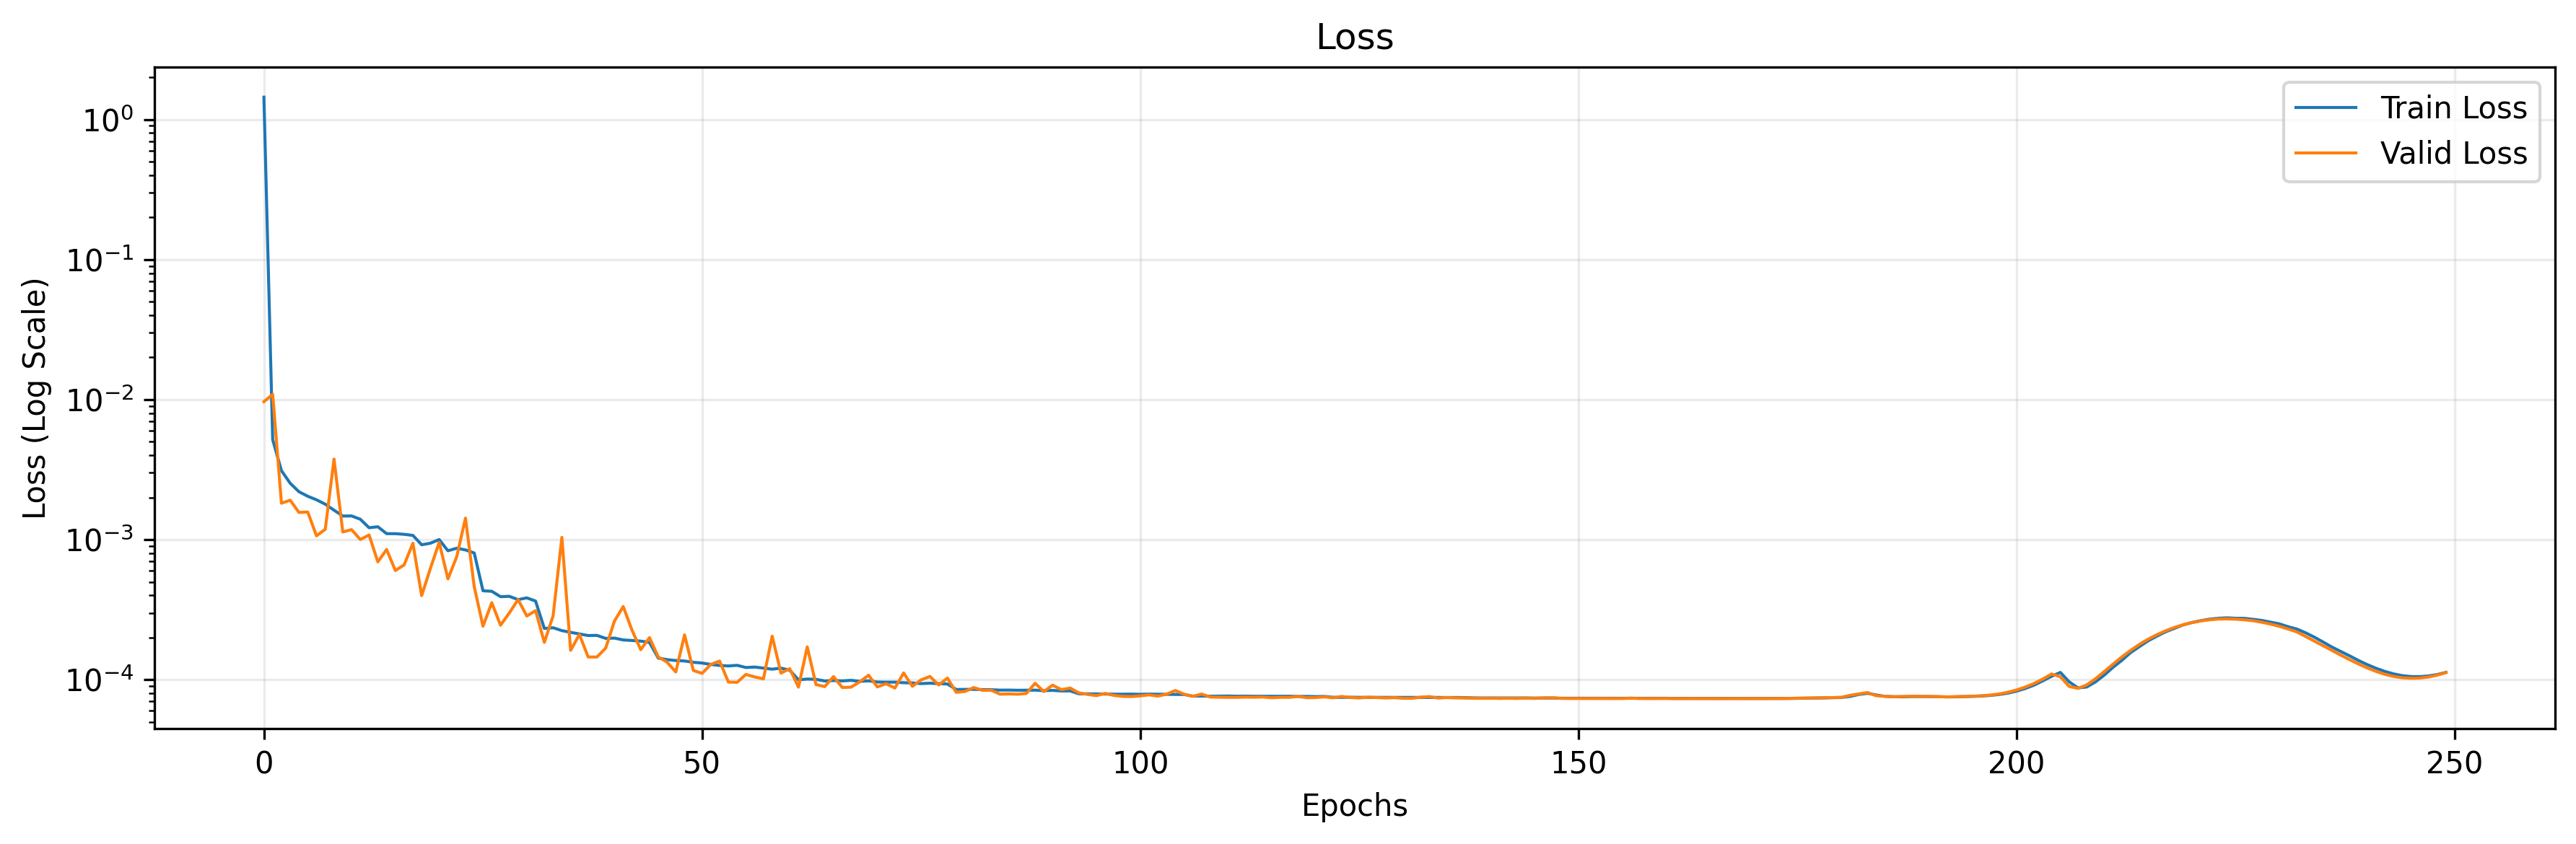

In [22]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

ax1.plot(train_losses, linewidth=1, label='Train Loss')
ax1.plot(valid_losses, linewidth=1, label='Valid Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (Log Scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(alpha=0.25)

fig.tight_layout()
plt.show()

## Validate Trained Models


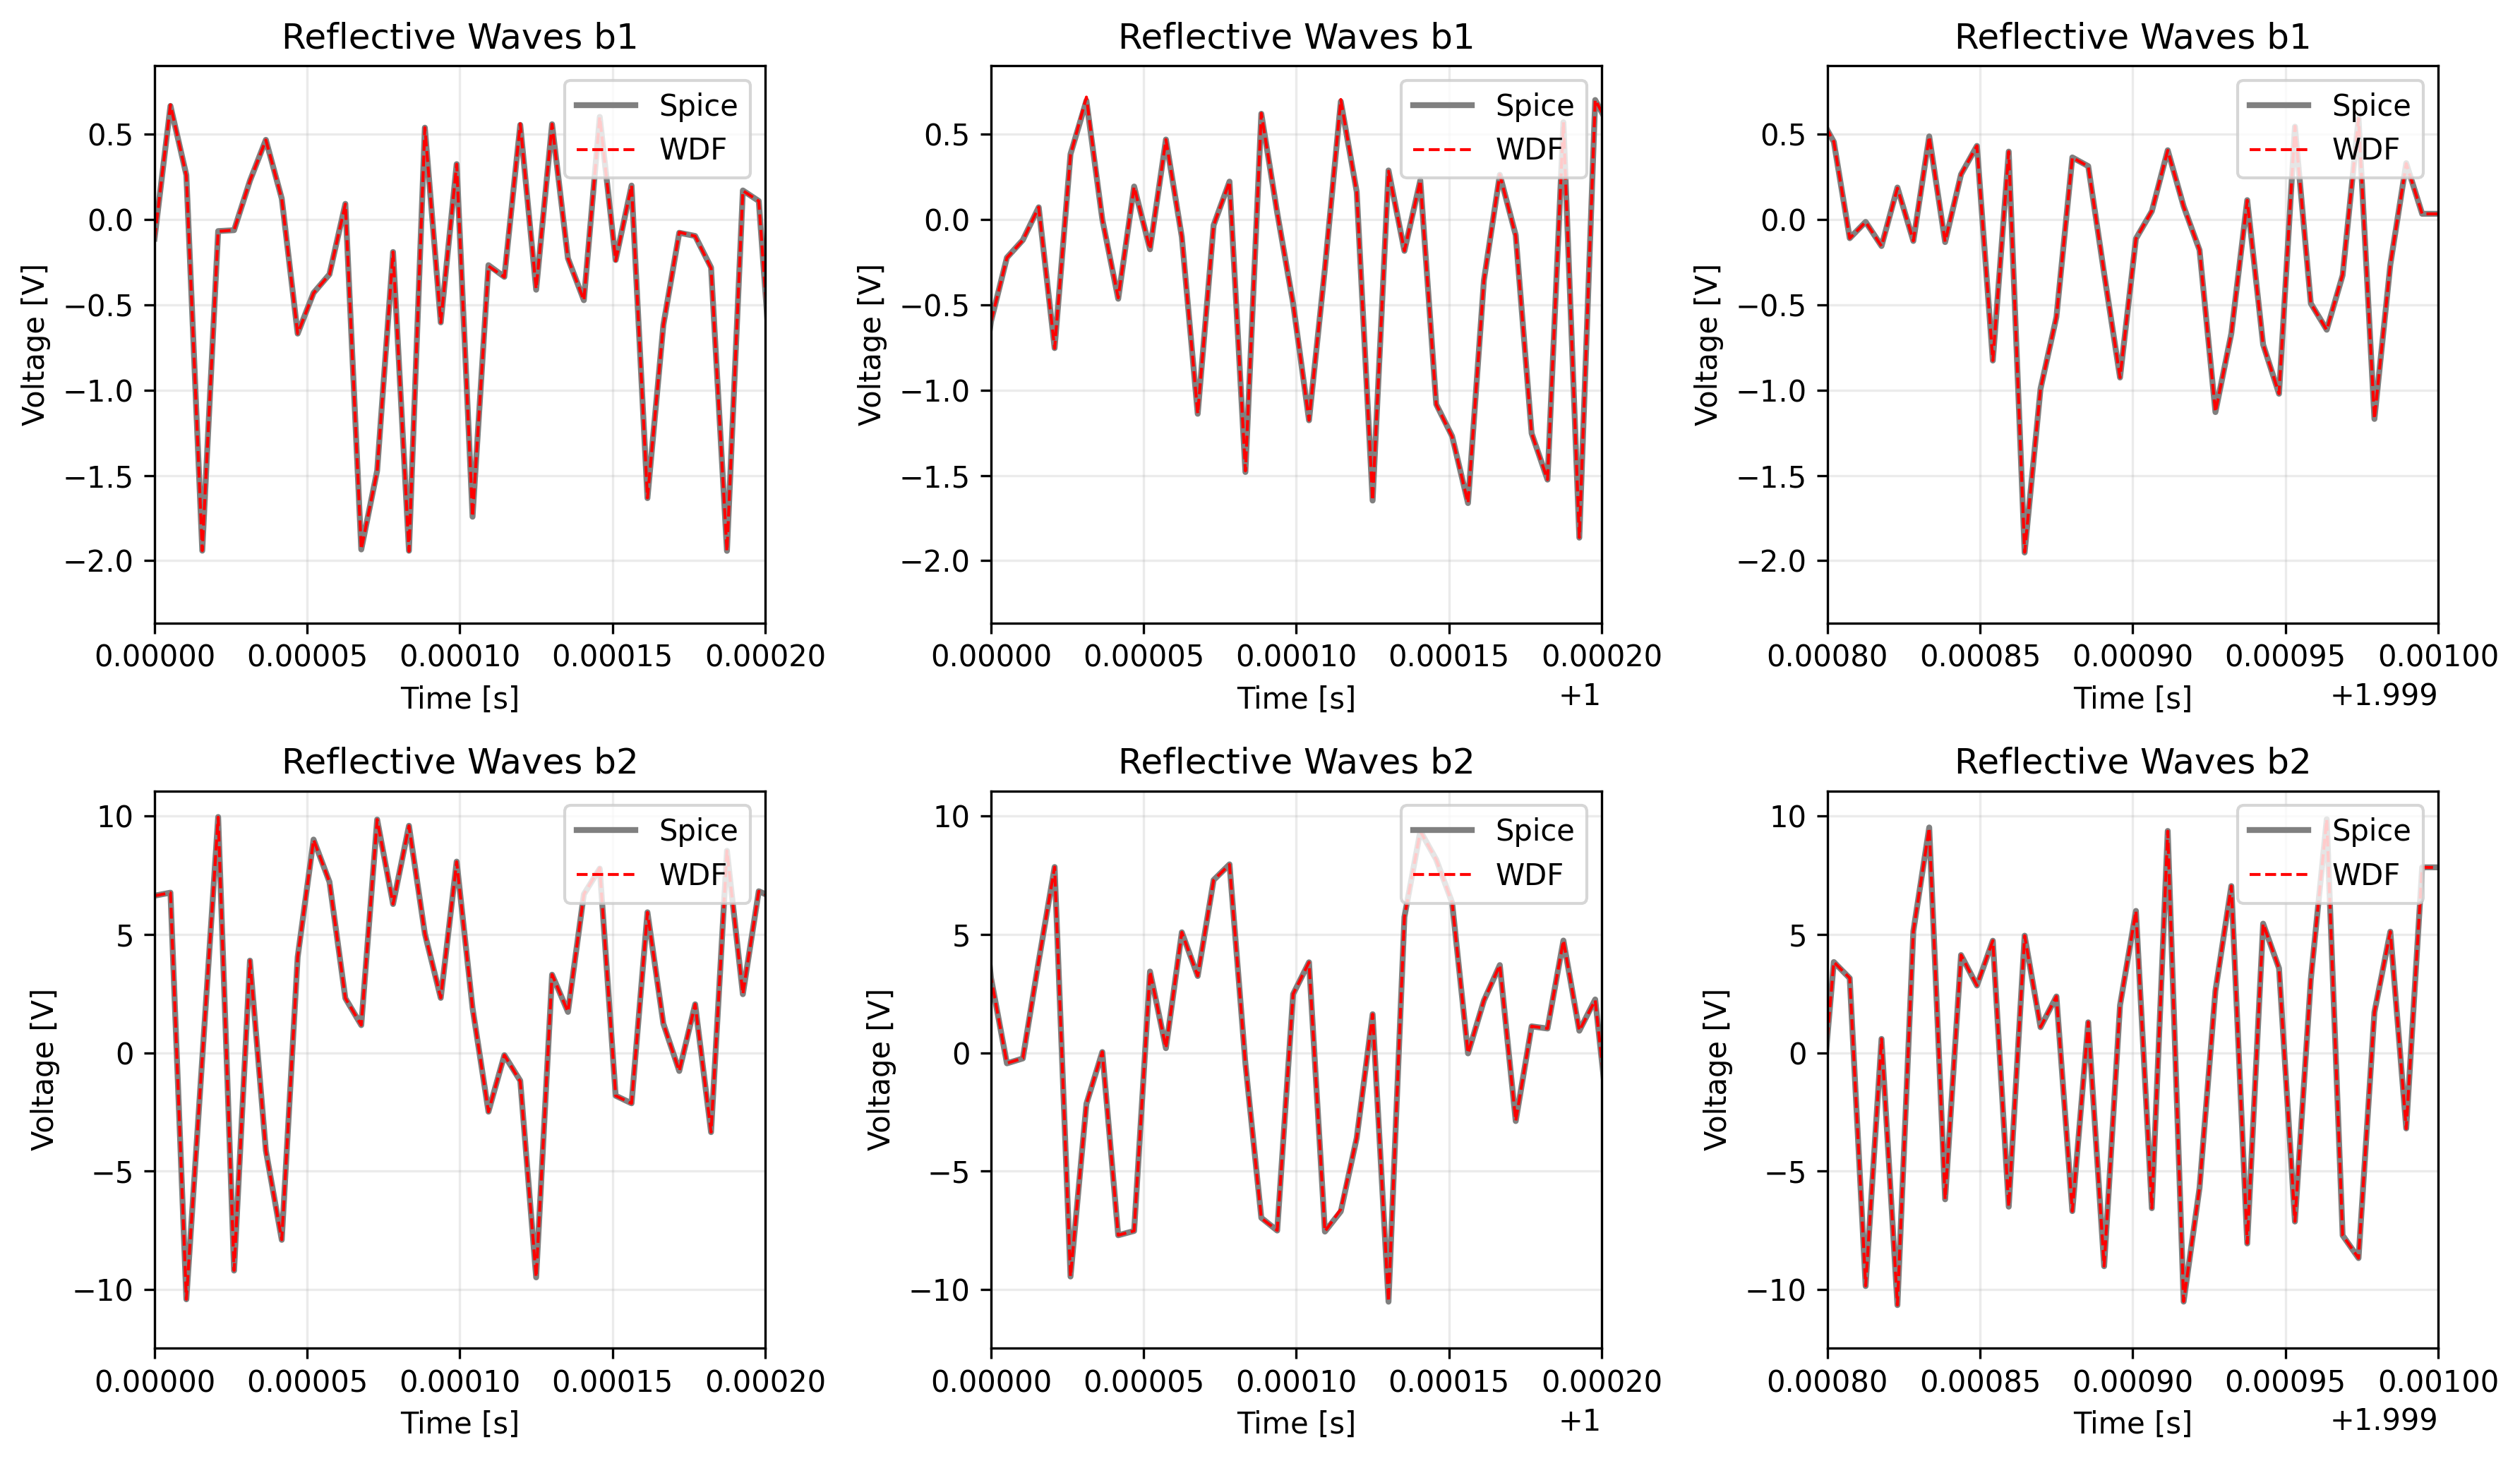

In [23]:
with torch.no_grad():
    b_pred = model(torch.tensor(aR, dtype=torch.float32))
    b_pred = b_pred.detach().numpy()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 7), dpi=300)

plot_duration = 2e-4
linewidth_spice = 2
linewidth_wdf = 1
grid_alpha = 0.25

xlim_start = (0, plot_duration)
xlim_mid = (time_duration / 2, time_duration / 2 + plot_duration)
xlim_end = (time_duration - plot_duration, time_duration)

ax1.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax1.plot(time_resample, b_pred[:, 0], color="red", linewidth=linewidth_wdf, linestyle='--', label='WDF')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]')
ax1.set_title('Reflective Waves b1')
ax1.legend(loc='upper right')
ax1.grid(alpha=grid_alpha)
ax1.set_xlim(xlim_start)

ax4.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax4.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Voltage [V]')
ax4.set_title('Reflective Waves b2')
ax4.legend(loc='upper right')
ax4.grid(alpha=grid_alpha)
ax4.set_xlim(xlim_start)

ax2.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax2.plot(time_resample, b_pred[:, 0], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')
ax2.set_title('Reflective Waves b1')
ax2.legend(loc='upper right')
ax2.grid(alpha=grid_alpha)
ax2.set_xlim(xlim_mid)

ax5.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax5.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Voltage [V]')
ax5.set_title('Reflective Waves b2')
ax5.legend(loc='upper right')
ax5.grid(alpha=grid_alpha)
ax5.set_xlim(xlim_mid)

ax3.plot(time_resample, b1, color="grey", linewidth=linewidth_spice, label='Spice')
ax3.plot(time_resample, b_pred[:, 0], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Voltage [V]')
ax3.set_title('Reflective Waves b1')
ax3.legend(loc='upper right')
ax3.grid(alpha=grid_alpha)
ax3.set_xlim(xlim_end)

ax6.plot(time_resample, b2, color="grey", linewidth=linewidth_spice, label='Spice')
ax6.plot(time_resample, b_pred[:, 1], color="red", linestyle='--', linewidth=linewidth_wdf, label='WDF')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Voltage [V]')
ax6.set_title('Reflective Waves b2')
ax6.legend(loc='upper right')
ax6.grid(alpha=grid_alpha)
ax6.set_xlim(xlim_end)

fig.tight_layout()
plt.show()
